In [33]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import Normalize

In [34]:
plot_path = "../../plots/"

In [35]:
plt.style.use('seaborn-v0_8-whitegrid')
cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)
plt.rcParams['image.cmap'] = cmap_name

In [36]:
ticksize = 20
fontsize = 28
axsize = 25
legendsize = 20
titlesize = 30
lw = 2.5

In [37]:
## Coordinates
lons = np.linspace(6.38,7.48,30)
lats = np.linspace(50.27,50.97,30)

# Original data

In [3]:
path = "../../data/application/"
file = xr.open_dataset(path + "1931_2020_raw.nc")

In [131]:
file = xr.open_dataset(path + "2021_raw.nc")
data = file.pr.sel(time = "2021-07").max(dim = "time", skipna = True)

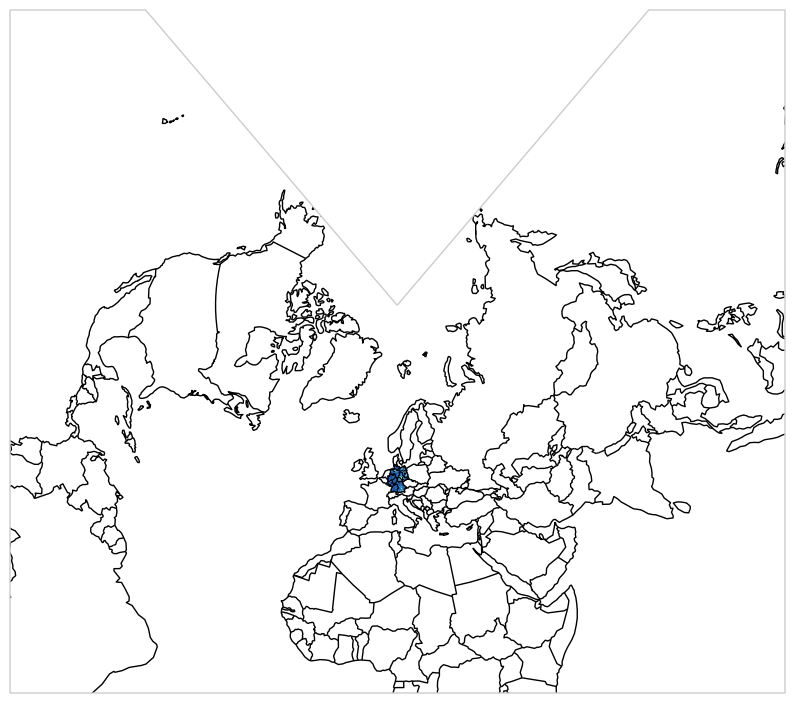

In [8]:

fig, axs = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_longitude=10, central_latitude=52,
                                                                        standard_parallels=(35,65), false_easting=4000000,
                                                                        false_northing=2800000)},figsize=(10,18))
axs.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.BORDERS)
ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_1.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                 edgecolor='black', facecolor = "None", lw = 0.3)

pcm = axs.pcolormesh(data.x, data.y, data)


(47.2, 55.2)

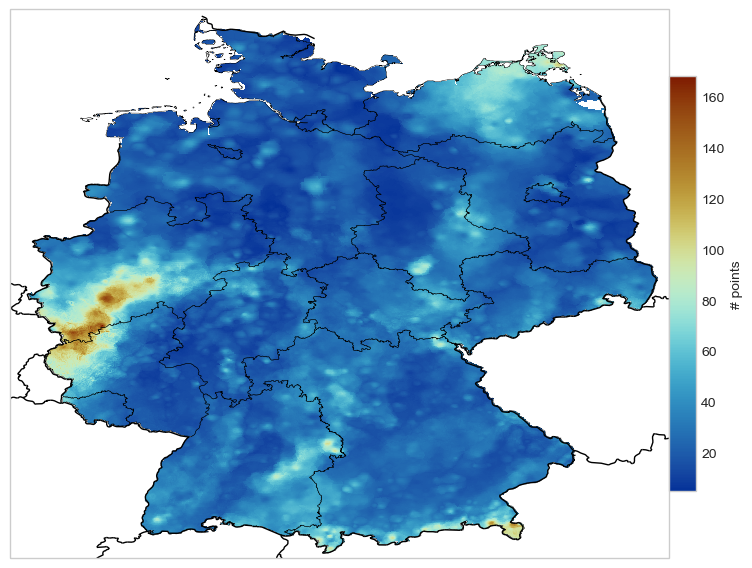

In [144]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(10,18))

axs.set_extent([lons[0],lons[1],lats[0],lats[1]])


ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_1.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                  edgecolor='black', facecolor = "None", lw = 0.3)
axs.add_feature(cfeature.BORDERS)
#axs.coastlines(resolution='10m')


pcm = axs.pcolormesh(data.lon, data.lat, data, transform = ccrs.PlateCarree())
fig.colorbar(pcm, ax=axs, label="# points", pad=0, shrink = 0.3, aspect = 15)


axs.set_xlim([5.6,15.2])
axs.set_ylim([47.2,55.2])

# Processed data

In [84]:
def plot_cities(axs):
    axs.plot(7.10066, 50.735851, ".", color = "black", markersize=15)
    axs.text(7.12, 50.735851, 'Bonn', fontsize = 20)

    axs.plot(6.959974, 50.938361, ".", color = "black", markersize=15)
    axs.text(6.985, 50.938361, 'Köln', fontsize = 20)

    axs.plot(6.486739, 50.799552, ".", color = "black", markersize=15)
    axs.text(6.50, 50.799552, 'Düren', fontsize = 20)

In [85]:
path = "../../data/application/"
year = "2021"
data = xr.open_dataset(path + f"{year}_month_max.nc").pr

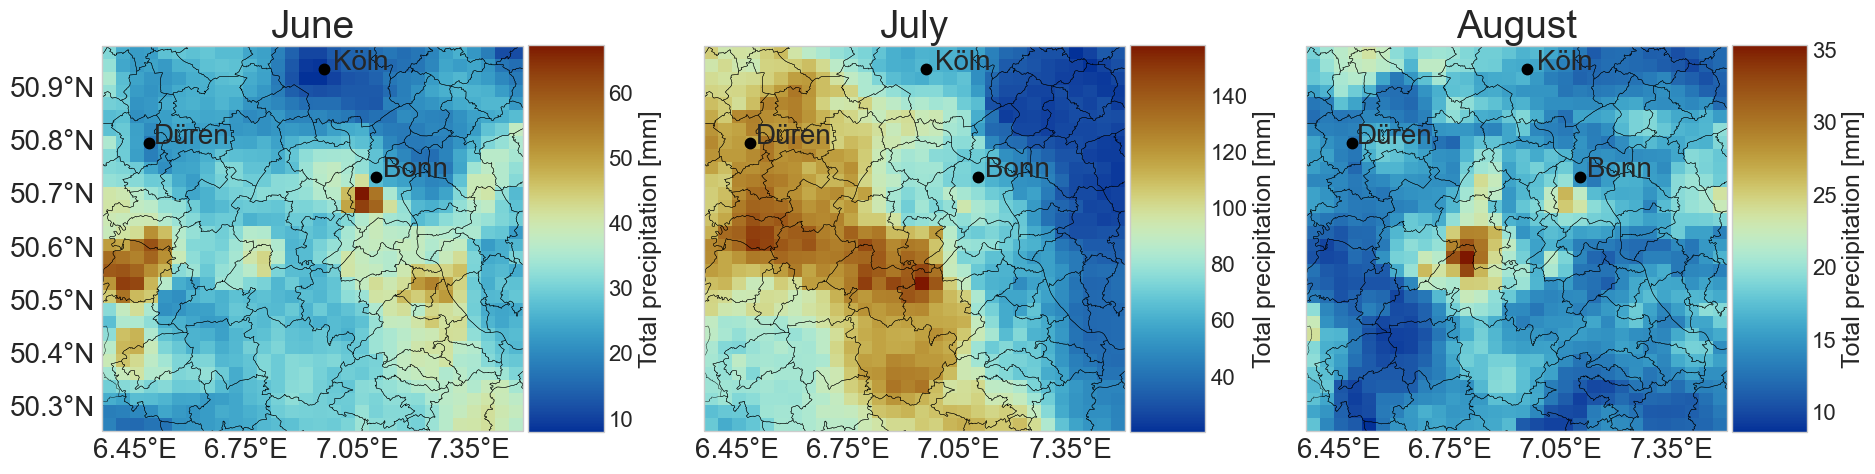

In [86]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(22,5))
months = ["June", "July", "August"]

for i in range(3):
    ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
    axs[i].add_geometries(ger_shape, ccrs.PlateCarree(),
                    edgecolor='black', facecolor = "None", lw = 0.3)
    pcm = axs[i].pcolormesh(lons, lats, data.isel(time = i))
    cb = fig.colorbar(pcm, ax=axs[i],  pad = 0.01, shrink = 10, aspect = 5.14)
    cb.set_label(label="Total precipitation [mm]",size=18)
    cb.ax.tick_params(labelsize=16)
    plot_cities(axs[i])
    axs[i].set_title(f"{months[i]}", fontsize = fontsize)
    gl = axs[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    if i > 0:
        gl.left_labels = False
    gl.xlabel_style = {'size': ticksize}
    gl.ylabel_style = {'size': ticksize}
    axs[i].set_aspect("auto")



plt.savefig(plot_path + f"{year}_tp.png", bbox_inches = "tight")

# Data with Fréchet margins

In [48]:

gev_params = {
    "loc1": 64.799623725,
    "loc_lat": -0.999680643,
    "loc_lon": 0.014852714,
    "loc_time": 0.001105532,
    "scale": 7.004518221,
    "shape": 0.105249698,
}


In [77]:
path = "../../data/application/"
year = "2022"
data = xr.open_dataset(path + f"{year}_month_max.nc").pr

In [78]:
def gev2frech(data, year):
    # Define lat lon grid
    lons = np.linspace(6.38, 7.48, 30)
    lats = np.linspace(50.27, 50.97, 30)
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Define year
    year_emb = year - 1931 + 1

    # Calculate parameters
    mu = (
        gev_params["loc1"]
        + lat2d * gev_params["loc_lat"]
        + lat2d * gev_params["loc_lon"]
        + year_emb * gev_params["loc_time"]
    )
    sigma = gev_params["scale"]
    gamma = gev_params["shape"]

    # Transformation
    result = np.power(1 + gamma * (data - mu) / sigma, (1 / gamma))

    return result


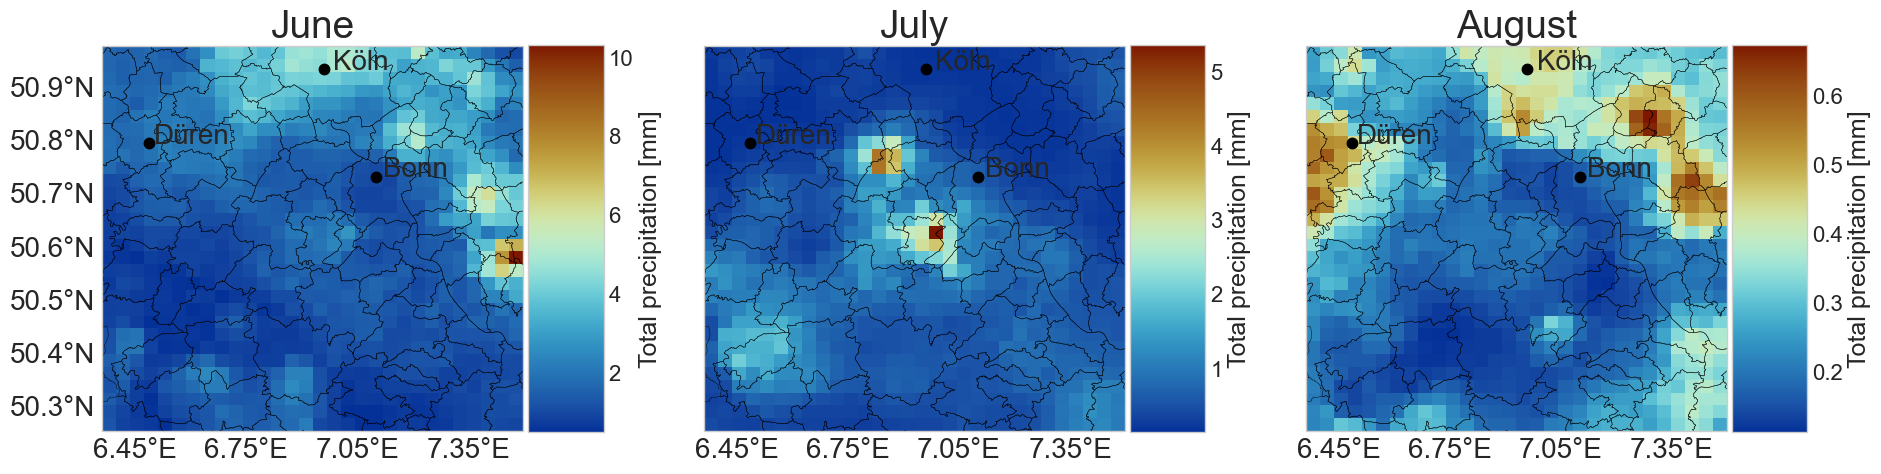

In [80]:
# Transformation
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(22,5))
months = ["June", "July", "August"]

for i in range(3):
    data_transformed = gev2frech(data.isel(time = i), year = 2022)
    ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
    axs[i].add_geometries(ger_shape, ccrs.PlateCarree(),
                    edgecolor='black', facecolor = "None", lw = 0.3)
    pcm = axs[i].pcolormesh(lons, lats, data_transformed)
    cb = fig.colorbar(pcm, ax=axs[i],  pad = 0.01, shrink = 10, aspect = 5.14)
    cb.set_label(label="Total precipitation [mm]",size=18)
    cb.ax.tick_params(labelsize=16)
    plot_cities(axs[i])
    axs[i].set_title(f"{months[i]}", fontsize = fontsize)
    gl = axs[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    if i > 0:
        gl.left_labels = False
    gl.xlabel_style = {'size': ticksize}
    gl.ylabel_style = {'size': ticksize}
    axs[i].set_aspect("auto")

plt.savefig(plot_path + f"{year}_frechet_tp.png", bbox_inches = "tight")
